<div class="alert alert-block alert-info">

<b>Thank you for contributing to TeachOpenCADD!</b>

</div>

<div class="alert alert-block alert-info">

<b>Set up your PR</b>: Please check out our <a href="https://github.com/volkamerlab/teachopencadd/issues/41">issue</a> on how to set up a PR for new talktorials, including standard checks and TODOs.

</div>

# T034 · E(3)-equivariant GNNs

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Joschka Groß, 2022, Chair for Modelling and Simulation, Saarland University,

*The examples used in this talktorial template are taken from [__Talktorial T001__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) and [__Talktorial T002__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb).*

<div class="alert alert-block alert-info">

<b>Cross-referencing talktorials</b>: If you want to cross-reference to existing talktorials in your notebook, please use the following formatting: <b>Talktorial T000</b>.

</div>

## Aim of this talktorial

**TODO**

### Contents in *Theory*

* Why 3D coordinates?
* Representing molecules as point clouds, mathematically
* Equivariance in euclidean space and why we care
* How to construct $\text{E}(n)$-equivariant models
* The QM9 dataset

### Contents in *Practical*

* Visualization
* Set up QM9 dataset
* [EGNN Model](#egnn_model)
* Demo: Plain GNNs are not E(3) invariant

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* Paper 
* Tutorial links
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory

<div class="alert alert-block alert-info">
    
<b>Figures</b>: Place images in the <code>images/</code> folder and include them using Markdown <code>![Figure title](images/some_figure.jpg)</code>. Add a figure caption in the format shown in the example.

</div>

### Why 3D coordinates?

* Some properties are more easily derived when 3D coordinates are known.
* Sometimes the task is to predict properties that are coupled to euclidean space, e.g. atom positions or forces that apply to atoms.
* We do not have to settle for one or the other. In practice, it is common to keep structural information (bonds) and add the 3D coordinates on top of the molecule graph representation and have a model which uses *both*.

For instance, one application that requires the use of 3D coordinates is protein-ligand docking. Work from 2022 by (TODO cite) uses E(3) equivariant graph neural networks as the backbone for a generative model that learns to predict potential ligand docking positions when additionally given protein structures with 3D information as input.

### Representing molecules as point clouds, mathematically
Here, we will just focus on atoms and their 3D positions and ignore structural bond information for the sake of simplicity. Our mathematical representations of molecules are thus point clouds, i.e., tuples $(Z, X)$ where $Z \in \mathbb{R}^{n \times d}$ is the atom feature matrix and $X \in \mathbb{R}^{n \times 3}$ captures the atom 3D-xyz coordinates. We will assume that the coordinates are derived from some conformer (TODO: refer to some talktorial?).

### Equivariance in euclidean space and why we care

In **Talktorial 034** you were taught why equi- and/or invariance w.r.t. to node permutations is a desirable model property when representing molecules by their molecular graphs. When embedding molecular graphs into euclidean space, we now also need to worry about euclidean symmetry groups. These are groups of transformations $g: \mathbb{R}^n \to \mathbb{R}^n$ that preserve distance, i.e., translations, rotations, reflections, or combinations thereof. For the euclidean space $\mathbb{R}^n$ with $n$ spatial dimensions, one typically distinguishes between
* the euclidean group $\text{E}(n)$, which consists of *all* distance-preserving transformations, and
* the special euclidean group $\text{SE}(n)$, which consists only of translations and rotations.
  
Say $\theta$ is a model that learns atom embeddings $H = \theta(X, Z) \in \mathbb{R}^{n \times q}$. We call $\theta$ $\text{E}(3)$-*invariant* if for all $g \in \text{E}(3)$
$$
\theta(X, g(Z)) = \theta(X, Z)
$$
where $g$ is applied row-wise to Z.

If we consider a model that makes predictions about objects which are coupled to the euclidean space, e.g. future atom positions $X' = \theta(X, Z) \in \mathbb{R}^{n \times 3}$, we can define $\text{E}(3)$-*equivariance* as
$$
\theta(X, g(Z)) = g(\theta(X, Z))
$$
for all $g \in \text{E}(3)$ applied in row-wise fashion.

So, why do we care about these properties?

Let's assume our goal was to train a model that predicts the docking position of a ligand when given a fixed protein structure, also with 3D coordinates. Would you trust a model that predicted a different relative position for the ligand when the protein that was simply rotated by 180 degrees along the z-axis? If your answer is no, then you should consider using a model that is $\text{E}(3)$-equivariant.
In addition to being a "natural" choice under such considerations, euclidean equivariance empirically also increases the sample complexity of training and improves the model's ability to generalize to unseen data.

### How to construct $\text{E}(n)$-equivariant models

Constructing such models is simple if you know that all $g \in \text{E}(3)$ are *distance-preserving*. We will not give a fully-fledged proof (if you are interested see e.g. Hoogeboom et. al.), but it shouldn't be too surprising that a model which only considers relative distances for its internal computations is guaranteed to be $E(3)$ invariant or equivariant respectively depending on whether the output coupled to the euclidean space.

TODO: MPNN definition, equivariant MPNN definition

### The QM9 dataset

The QM9 dataset is part of MoleculeNet and consists of ~130k small organic molecules with up to 9 heavy atoms. It also includes targets for various geometric, energetic, electronic and thermodynamic properties. Crucially, it also includes 3D coordinates, which makes it a suitable for this talktorial.

## Practical

For the practical part we will be working with a version of QM9 that is already included in PyTorch Geometric, as implementing the dataset from scratch would go beyond the scope of this talktorial. We will just inspect the data and briefly discuss how point clouds are represented as tensors. Then we will demonstrate how one could use plain GNNs to work with point clouds and why this approach would yield models that are not $\text{E}(3)$ invariant/equivariant. Finally, you will learn how to implement, train and evaluate equivariant GNNs.

In [1]:
from itertools import chain
from functools import partial
from typing import Any, Optional, Callable, Tuple
import math

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

import torch_geometric
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

from torch_scatter import scatter

import matplotlib as mpl
import matplotlib.pyplot as plt


<div class="alert alert-block alert-info">

<b>Relative paths</b>: Please define all paths relative to this talktorial's path by using the global variable <code>HERE</code>.
If your talktorial has input/output data, please define the global <code>DATA</code>, which points to this talktorial's data folder (check out the default folder structure of each talktorial).
    
</div>

### Visualization
In order to visualize model inputs and embeddings we will project the 3D-xyz point clouds to the z-plane because 2D point clouds are easier to visualize. The following functions will be used later on to visualize properties of plain GNNs and E(3) equivariant GNNs.

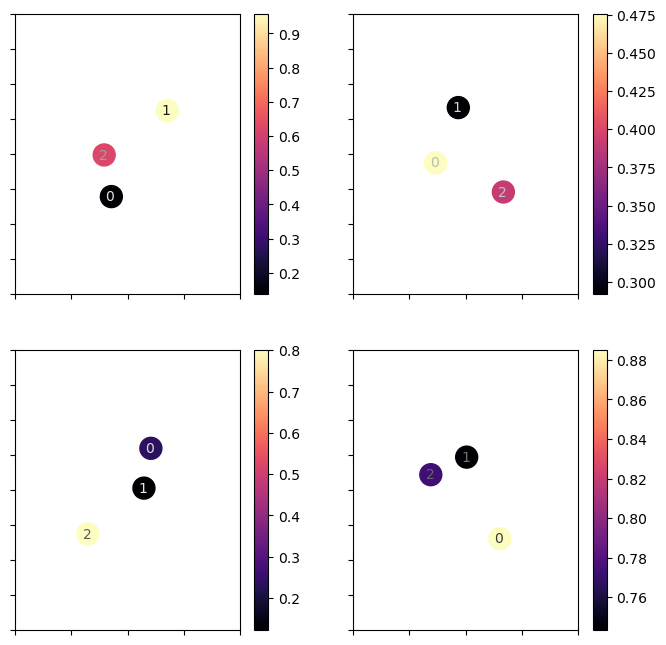

In [2]:
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """Convert rgb colors to perceived brighness values in [0,1]

    Parameters
    ----------
    rgb : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1 * b

def plot_point_cloud_2d(
    color: np.ndarray,
    pos: np.ndarray,
    cmap: mpl.colors.Colormap = mpl.colormaps["magma"],
    ax: Optional[mpl.axis.Axis] = None,
    point_size: float = 250.0,
    label_axes: bool = False,
    normalize_pos: bool = True,
    annotate_points: bool = True,
):
    """_summary_

    Parameters
    ----------
    color : np.ndarray
        _description_
    pos : np.ndarray
        _description_
    cmap : mpl.colors.Colormap, optional
        _description_, by default mpl.colormaps["magma"]
    ax : Optional[mpl.axis.Axis], optional
        _description_, by default None
    point_size : float, optional
        _description_, by default 250.0
    label_axes : bool, optional
        _description_, by default False
    normalize_pos : bool, optional
        _description_, by default True
    annotate_points : bool, optional
        _description_, by default True
    """
    if ax is None:
        fig, ax = plt.subplots()
    # normalize coordinates for better comparability
    # when comparing point clouds
    if normalize_pos:
        pos = (pos - pos.mean(axis=1, keepdims=True)) / pos.std(axis=1, keepdims=True)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
    x, y = pos
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
    sc = ax.scatter(x, y, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc)
    if annotate_points:
        _colors = cmap(color)
        rgb = np.transpose(_colors)[:3, :]
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, li) in enumerate(zip(x, y, brightness)):
            text = f"${i}$"
            num_digits = len(text) - 2
            offset = (-4 -2*num_digits, -4)
            ax.annotate(
                text="$%d$" % i,
                xy=(xi, yi),
                xytext=offset,
                textcoords="offset pixels",
                # annotation color based on perceived color brightness
                # for readability
                color=[1 - li] * 3
            )
            

# testing
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
for ax in chain(*axes):
    pos = np.random.rand(2, 3)
    color = np.random.rand(3)
    plot_point_cloud_2d(color, pos, ax=ax)
    

In [3]:
def plot_model_input(data: Data, ax: mpl.axis.Axis):
    """_summary_

    Parameters
    ----------
    data : Data
        _description_
    ax : mpl.axis.Axis
        _description_
    """
    x, pos = data.x, data.pos 
    # use atomic number as color
    x = x[:, 0].flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    plot_point_cloud_2d(x, pos, ax=ax, normalize_pos=False)

def plot_model_embedding(data: Data, model: Callable[[Data], Tuple[Tensor, Tensor]], ax: mpl.axis.Axis):
    """_summary_

    Parameters
    ----------
    data : Data
        _description_
    model : Callable[[Data], Tuple[Tensor, Tensor]]
        _description_
    ax : mpl.axis.Axis
        _description_
    """
    x, pos = model(data)
    x = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    plot_point_cloud_2d(x, pos, ax=ax, normalize_pos=False)

### Set up QM9 dataset

We use the QM9 dataset already included in pytorch geometric. For the sake of this tutorial we will restrict ourselves to small molecules with at most 8 heavy atoms.

In [4]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object where atomic number is the *zeroth* atom (node)
    feature in `Data.x`

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    # the torch geometric qm9 dataset stores
    # the atomic number in the first (zeroth) 
    # node-feature channel
    return (qm9_data.x[:, 0] != 1).sum()

def prepare_data(
    qm9_data: Data,
    target_mean: float = 0,
    target_std: float = 1,
    target: int = 5,
) -> Data:
    """ TODO

    Parameters
    ----------
    qm9_data : Data
        _description_
    target_mean : float, optional
        _description_, by default 0
    target_std : float, optional
        _description_, by default 1
    target : int, optional
        _description_, by default 5

    Returns
    -------
    Data
        _description_
    """
    return Data(
        x=qm9_data.x,
        edge_index=qm9_data.edge_index,
        y=(qm9_data.y[:, target].view(-1, 1) - target_mean) / target_std,
        pos=qm9_data.pos
    )

# TODO standardize target somehow?
dataset = QM9("data", pre_filter=lambda data: num_heavy_atoms(data) < 9, transform=prepare_data)

print(f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}")

Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 21800


### Demo: Plain GNNs are not E(3) invariant
A naive way to incorporate 3D coordinates into a GNN for molecular graphs would be to interpret them as atom-level features. 
It is easy to implement a transformation which does exactly this.

In [5]:
def add_coordinates_as_features(data: Data, num_spatial_dims_used: int = 3) -> Data:
    """Add separately stored atom coordinates
    to the node (atom) features of a molecular graph data object.

    Parameters
    ----------
    data : Data
        A pytorch geometric qm9 data object representing a small molecule
        
    num_spatial_dims_used : int
        Use the first `num_spatial_dims_used` as the coordinates.
        Helps with visualization, where we look at 2D point clouds.

    Returns
    -------
    Data
        Modified data object where the coordinates have been added as atom features.
    """
    new_data = data.clone()
    new_data.x = torch.cat((data.x, data.pos[:, :num_spatial_dims_used]), dim=-1)
    new_data.pos = data.pos[:, :num_spatial_dims_used]
    return new_data

This approach is problematic because the corresponding atom embeddings of a regular GNN (from which we would also derive our final predictions) will not be $\text{E}(3)$-equivariant. This is easily demonstrated by visualizing the behavior of a plain GCN. To ease the visualization we restrict ourselves to 2D coordinates by first projecting the 3D-xyz coordinates to the z-plane.

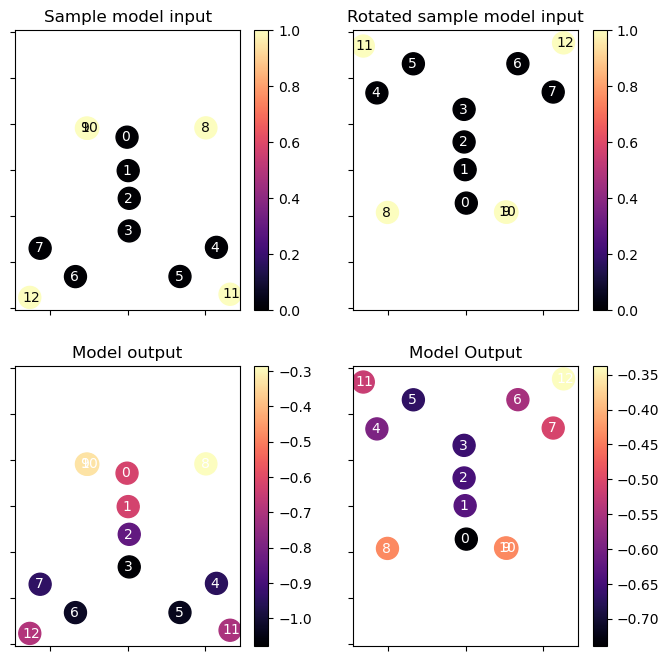

In [11]:
# *some* datapoint from qm9
sample_data = dataset[20160].clone()

# apply an E(2) transformation, in this case rotation by 180 degrees
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = - rotated_sample_data.pos

# prepare data for GCN
sample_data = add_coordinates_as_features(sample_data, num_spatial_dims_used=2)
rotated_sample_data = add_coordinates_as_features(rotated_sample_data, num_spatial_dims_used=2)

# initialize a GCN with 2 hidden layers that outputs 1-dimensional node embeddings
model = geom_nn.models.GCN(sample_data.x.size(1), 4, 2, 1)
model_fwd = lambda data: (model(data.x, data.edge_index), data.pos)

# make a plot that demonstrates non-equivariance
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

axes[0][0].set_title("Sample model input")
plot_model_input(sample_data, axes[0][0])

axes[0][1].set_title("Rotated sample model input")
plot_model_input(rotated_sample_data, axes[0][1])

axes[1][0].set_title("Model output")
plot_model_embedding(sample_data, model_fwd, axes[1][0])

axes[1][1].set_title("Model Output")
plot_model_embedding(rotated_sample_data, model_fwd, axes[1][1])

### EGNN Model

<a id='egnn_model'></a>

We now implement an E(3) equivariant GNN based on the principles outlined in the [theory section](...). This GNN is based on the implementation by Hoogeboom et. al.

In [7]:
# TODO thought this would be more complicated
# maybe can remove this function and do it inplace
def aggregate_messages(
    messages: Tensor, target_index: LongTensor, aggr: str = "sum"
) -> Tensor:
    return scatter(messages, target_index, dim=0, reduce=aggr)


class EquivariantMPLayer(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, act: nn.Module) -> None:
        super().__init__()
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)
        # message input: source node, target node, distance
        message_input_size = 2 * in_channels + 1
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
            nn.Linear(hidden_channels, hidden_channels),
            act,
        )
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
            nn.Linear(hidden_channels, hidden_channels),
        )
        self.coord_gate_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            act,
            nn.Linear(hidden_channels, 1),
            nn.Tanh(),
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # j
        target_node_embed: Tensor,  # i
        rs_node_dist: Tensor,
    ):
        inp = torch.cat((source_node_embed, target_node_embed, rs_node_dist), dim=-1)
        return self.message_mlp(inp)

    def coord_message_function(
        self,
        node_messages: Tensor,
        pos_diff: Tensor,
    ):
        return pos_diff * self.coord_gate_mlp(node_messages)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        diff = xj - xi
        rsdist = diff.pow(2).sum(1, keepdim=True)
        return diff, rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        diff, rsdist = self.compute_distances(node_pos, edge_index)

        node_messages = self.node_message_function(
            node_embed[row], node_embed[col], rsdist
        )
        aggr_node_messages = aggregate_messages(node_messages, col, aggr="sum")
        new_node_embed = self.residual_proj(node_embed) + aggr_node_messages

        pos_messages = self.coord_message_function(node_messages, diff)
        aggr_pos_messages = aggregate_messages(pos_messages, col, aggr="mean")
        new_pos = node_pos + aggr_pos_messages
        return new_node_embed, new_pos


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int,
        output_channels: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
    ) -> None:
        super().__init__()
        if output_channels is None:
            output_channels = hidden_channels
        self.act = (
            nn.ReLU()
        )  # usually configurable, here we just use relu for simplicity
        self.f0 = nn.Linear(num_node_features, hidden_channels)
        channels = [hidden_channels] * (num_mp_layers) + [output_channels]
        self.layers = nn.ModuleList()
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(d_in, d_out, self.act)
            self.layers.append(layer)

        self.readout = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            self.act,
            nn.Linear(hidden_channels, target_size),
        )

    def encode(self, data: Data):
        x = self.f0(data.x)
        pos = data.pos
        edge_index = data.edge_index
        for layer in self.layers:
            x, pos = layer(x, pos, edge_index)
        return x, pos

    def predict(self, x, pos, batch):
        aggr = self.readout(x, batch)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> torch.Tensor:
        x, pos = self.encode(data)
        pred = self.predict(x, pos, data.batch)
        return pred


We can demonstrate evidence that this model is indeed $\text{E}(n)$ equivariant by repeating the experiment we performed earlier with a plain GNN.

In [8]:
model = EquivariantGNN(
    num_node_features=dataset[0].x.size(1),
    hidden_channels=16,
    output_channels=1
)

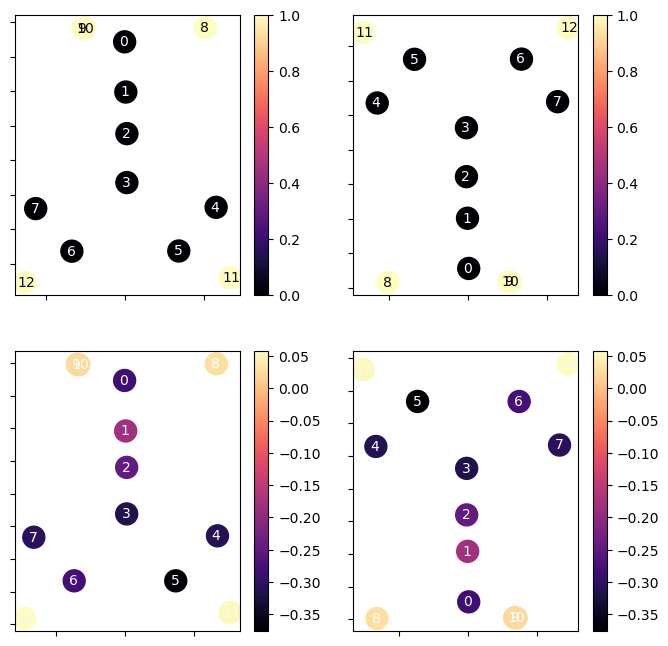

In [9]:
# idx = np.random.randint(len(dataset))
idx = 20160
data = dataset[idx].clone()

# project xyz coordinates onto z-plane
data.pos = data.pos[:, :2]

# rotate clockwise by 180 degrees
rotated_data = data.clone()
rotated_data.pos = -data.pos


fig, ax = plt.subplots(2, 2, figsize=(8,8))
plot_model_input(data, ax[0][0])
plot_model_input(rotated_data, ax[0][1])
plot_model_embedding(data, model.encode, ax[1][0])
plot_model_embedding(rotated_data, model.encode, ax[1][1])


### Model training

In [10]:
def training_step(
    model: EquivariantGNN,
    data_batch: Data,
    optim: torch.optim.Optimizer,
    criterion: Callable[[Tensor, Tensor], Tensor],
) -> float:
    optim.zero_grad()
    pred = model.forward(data_batch)
    target = data_batch.y
    loss = criterion(pred, target)
    loss.backward()
    optim.step()
    return loss.detach().item()


# we will be using mean absolute error
# for validation and testing
def mae(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    return (pred - target).abs().sum(batch_dim)


@torch.no_grad()
def validation_step(
    model: EquivariantGNN,
    data_batch: Data,
    criterion: Callable[[Tensor, Tensor], Tensor],
) -> float:
    pred = model.forward(data_batch)
    target = data_batch.y
    validation_measure = criterion(pred, target)
    return validation_measure.item()


def train(
    dataset: Dataset,
    train_split: np.ndarray,
    val_split: np.ndarray,
    model: Optional[EquivariantGNN] = None,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
) -> EquivariantGNN:
    # initialize model if not given
    if model is None:
        num_node_features = dataset[0].x.size(1)
        model = EquivariantGNN(
            num_node_features=num_node_features,
            hidden_channels=64,
            target_size=1,
            num_mp_layers=3,
        )
    
    # create data loaders
    train_loader = DataLoader(dataset[train_split], batch_size=batch_size)
    val_loader = DataLoader(dataset[val_split], batch_size=batch_size)
    
    # setup optimizer and loss
    optim = torch.optim.Adam(model.parameters(), lr)
    loss_fn = nn.MSELoss()
    
    for i_epoch in range(1, num_epochs + 1) :
        print(f"Epoch {i_epoch} / {num_epochs}")
        
        # run training epoch
        pbar = tqdm(train_loader)
        for data in pbar:
            train_loss = training_step(model, data, optim, loss_fn)
            desc = f"   Training loss: {train_loss:.3f}"
            pbar.set_description(desc)
        
        train_desc_len = len(desc)
       
        # run validation 
        pbar = tqdm(val_loader)
        val_mae = 0 
        for data in pbar:
            val_mae += validation_step(model, data, criterion=mae)
            desc = "Validating..."
            desc = " "*(train_desc_len-len(desc)) + desc
            pbar.set_description(desc)
        
        val_mae = val_mae / len(val_loader)
        print(f"   Validation MAE: {val_mae:.3f}")
            

num_examples = len(dataset)

# percentages of the data used for train/val/test data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

# random train/val/test split
dataset.shuffle()
train_split = np.arange(int(train_ratio * num_examples))
val_split = np.arange(int(val_ratio * num_examples)) + train_split.shape[0]

train(dataset, train_split, val_split, num_epochs=5, lr=2e-4, batch_size=64)

Epoch 1 / 5


              Validating...: 100%|██████████| 35/35 [00:00<00:00, 49.45it/s]


   Validation MAE: 7027.675
Epoch 2 / 5


              Validating...: 100%|██████████| 35/35 [00:00<00:00, 77.50it/s]


   Validation MAE: 6784.331
Epoch 3 / 5


              Validating...: 100%|██████████| 35/35 [00:00<00:00, 76.99it/s]


   Validation MAE: 6547.986
Epoch 4 / 5


              Validating...: 100%|██████████| 35/35 [00:00<00:00, 75.15it/s]


   Validation MAE: 6315.265
Epoch 5 / 5


              Validating...: 100%|██████████| 35/35 [00:00<00:00, 80.06it/s]

   Validation MAE: 6098.031


### Model Evaluation

In [ ]:
# TODO

## Discussion

* Discuss vector valued features
* Discuss implementation with dense edge/adjacency tensor instead of sparse tensors

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>